In [4]:
import os
import pandas as pd

# 1 Control Dataset Analysis

In the first step, I load all the necessary data that has been processed beforehand. From our experiment, data has been divided into 6 data sets of which each describes a
different group/different action in the experiment.

- In the *control* data sets, participants were picking their actions based on their current costs
- In the *treatment* data sets, participants were picking not only their actions, but also their prediction about the opponent's behavior

In [5]:
def load_data(group):
    assert group in ['control', 'treatment']
    data_processed = {}
    for res_file in os.listdir("../data/data_processed/"):
        if group in res_file:
            data_processed[str(res_file).split(".")[0]] = pd.read_csv(f"../data/data_processed/{res_file}").drop("Unnamed: 0", axis=1)

    print(f"Loaded data: {data_processed.keys()}")
    return data_processed

In [6]:
data_processed = load_data('control')

Loaded data: dict_keys(['control_actions', 'control_pred'])


In [7]:
def data_into_df(df_dict):
    df_out = pd.concat(df_dict.values(), axis=1)
    df_out = df_out.loc[:, ~df_out.columns.duplicated()]
    return df_out

data_into_df(data_processed)

,id,p_choices,cost,prediction
0,0,1,10,1
1,0,2,30,2
2,0,2,50,2
3,0,2,70,2
4,0,2,90,2
...,...,...,...,...
215,21,1,110,2
216,21,2,130,2
217,21,2,150,2
218,21,2,170,2


Hereby I concatenate the dataframes for both treatment and control groups

In [8]:
control_full_df = data_into_df(load_data('control'))
control_full_df

Loaded data: dict_keys(['control_actions', 'control_pred'])


,id,p_choices,cost,prediction
0,0,1,10,1
1,0,2,30,2
2,0,2,50,2
3,0,2,70,2
4,0,2,90,2
...,...,...,...,...
215,21,1,110,2
216,21,2,130,2
217,21,2,150,2
218,21,2,170,2


Now I have both data sets ready for further analysis

# 1 Analysing the Control Data Set

In the next step, I will identify the costs under which the players do change their actions. THis would yield two important information:
- are the players consistent?
- what is the overall strategy for the players?

In [9]:
def get_player_type(row_value):
    if len(row_value) > 1:
        return 'irrational'
    elif len(row_value) == 0:
        return 'static'
    elif row_value[0][1] == 1:
        return 'aggresive'
    elif row_value[0][1] == 2:
        return 'peaceful'

In [10]:
def get_cutoff(df, action_col, cost_col='cost', id_col='id'):
    """
    To each unique id, assign all costs at which his strategy has changed
    """
    cutoff = {k: [] for k in df[id_col].unique()}
    for i in range(len(df[cost_col]) - 1):
        if df[action_col][i + 1] != df[action_col][i] and df[id_col][i + 1] == df[id_col][i]:
            cutoff[df[id_col][i]].append((df[cost_col][i], df[action_col][i]))

    df_cutoffs = pd.DataFrame({'id': cutoff.keys(),
                               f'{action_col}_cutoff': [v for v in cutoff.values()]})

    df_cutoffs[f'{action_col}_player_type'] = df_cutoffs[f'{action_col}_cutoff'].apply(get_player_type)

    return df_cutoffs

In [11]:
def get_all_cutoffs(df, action_cols):
    df_out = get_cutoff(df, action_cols[0])
    for col in action_cols[1:]:
        df_out = df_out.merge(get_cutoff(df, col))
    return df_out

In [12]:
control_cutoff_df = get_all_cutoffs(control_full_df, ['p_choices', 'prediction'])
control_cutoff_df

,id,p_choices_cutoff,p_choices_player_type,prediction_cutoff,prediction_player_type
0,0,"[(10, 1)]",aggresive,"[(10, 1)]",aggresive
1,1,"[(50, 1), (70, 2), (130, 1)]",irrational,"[(70, 2), (130, 1)]",irrational
2,2,"[(70, 1)]",aggresive,"[(50, 1)]",aggresive
3,3,"[(30, 1)]",aggresive,"[(30, 1)]",aggresive
4,4,"[(30, 1), (110, 2), (130, 1)]",irrational,"[(10, 1), (110, 2), (130, 1)]",irrational
5,5,"[(30, 1)]",aggresive,"[(30, 1)]",aggresive
6,6,"[(30, 2), (50, 1)]",irrational,"[(50, 1)]",aggresive
7,7,"[(10, 2), (30, 1)]",irrational,"[(10, 1)]",aggresive
8,8,"[(90, 1)]",aggresive,"[(90, 1)]",aggresive
9,9,"[(90, 1)]",aggresive,"[(90, 1)]",aggresive


In [13]:
def get_first_cutoffs(df, cutoff_cols):
    df_out = df.copy()
    for cutoff_col in cutoff_cols:
        df_out[f'{cutoff_col}_first'] = df_out[cutoff_col].apply(lambda x: x[0][0])
    return df_out

In [14]:
cutoffs_full = get_first_cutoffs(control_cutoff_df, ['p_choices_cutoff', 'prediction_cutoff'])
cutoffs_full

,id,p_choices_cutoff,p_choices_player_type,prediction_cutoff,prediction_player_type,p_choices_cutoff_first,prediction_cutoff_first
0,0,"[(10, 1)]",aggresive,"[(10, 1)]",aggresive,10,10
1,1,"[(50, 1), (70, 2), (130, 1)]",irrational,"[(70, 2), (130, 1)]",irrational,50,70
2,2,"[(70, 1)]",aggresive,"[(50, 1)]",aggresive,70,50
3,3,"[(30, 1)]",aggresive,"[(30, 1)]",aggresive,30,30
4,4,"[(30, 1), (110, 2), (130, 1)]",irrational,"[(10, 1), (110, 2), (130, 1)]",irrational,30,10
5,5,"[(30, 1)]",aggresive,"[(30, 1)]",aggresive,30,30
6,6,"[(30, 2), (50, 1)]",irrational,"[(50, 1)]",aggresive,30,50
7,7,"[(10, 2), (30, 1)]",irrational,"[(10, 1)]",aggresive,10,10
8,8,"[(90, 1)]",aggresive,"[(90, 1)]",aggresive,90,90
9,9,"[(90, 1)]",aggresive,"[(90, 1)]",aggresive,90,90


In [15]:
def get_combination_count(df, action_cols):
    return df.groupby(action_cols).size().reset_index().rename(columns={0: 'combination_count'})

In [16]:
get_combination_count(cutoffs_full, ['p_choices_player_type', 'prediction_player_type'])

,p_choices_player_type,prediction_player_type,combination_count
0,aggresive,aggresive,17
1,irrational,aggresive,2
2,irrational,irrational,3


In [21]:
control_rational = cutoffs_full.loc[(cutoffs_full['p_choices_player_type'] != 'irrational') & (cutoffs_full['prediction_player_type'] != 'irrational')][['id', 'p_choices_cutoff_first', 'prediction_cutoff_first']]

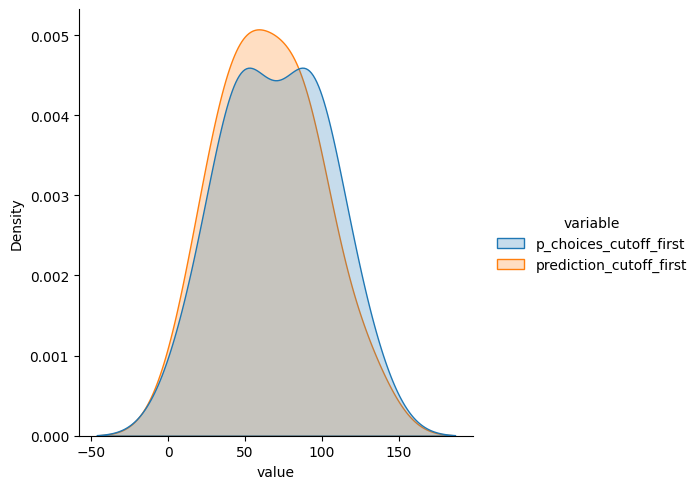

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
control_rational_plot = control_rational.melt(id_vars='id')
kde_plot = sns.displot(control_rational_plot, x='value', hue='variable', kind='kde', fill=True)
kde_plot

I can see that majority of the players had started playing the *aggressive* action, changing it only once. However, some players haven't changed the strategy at all and
some have changed it twice which is a proof of their irrationality

In [ ]:
cutoffs_full